# Introduction/Business Problem . 
A company want to relocate from Toronto to New York. It wants to find a similar borough by venue composition. In other words, we don't use the venue number direcly, in stead we use the percentage contribution of categories , say Arts & Entertainment, Food, Nightlife Spot, Outdoors & Recreation, Residence, Shop & Service and Travel & Transport.

![Pie Chart](https://github.com/MRYingLEE/CapstoneProjectNotebook/blob/master/pie.png)


# Data

**Toronto Data: **Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M.


We get the borough;s information from the previous excercise.

**New York Data: **The link to the dataset of New York: https://geo.nyu.edu/catalog/nyu_2451_34572


In [2]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


**Foursquare Data:**
We get the venues and their categories data from Foursquare.com .

The primary challenge is to fetch data from Foursquare.  For every call, there is a limit of 50 venues to return. So in orde to fetch more data, If we make venue search calls by category. If we fetch data for all categories, the dataset could have millions of rows. But due to the calle limit, It definitely fail for every time. So we categorize the data into only 7 top categories.
As a balance, we fetch data by 7 primary categories. And in order to limit the results per call, we choose a small radius.


In order to break the call limit, I applied 5 Foursquare accounts to download data.

# The Method
1. We collect venue data from Foursquare.

2. We statistics the venue data and form the pivot table as the following:
      
      
      Count                 Category 1, Category 2,... Category 7
Boroughs

3. We use category count per borough/ Total venues per borough to make the data percent based.

      
      percent                 Category 1, Category 2,... Category 7
Boroughs


4. We use the K means cluster of SKLearn to cluster the boroughs. In order to find the best K parameter. We will use GridSearch.

# To load Toronto data, which is generated in another notebook in the same folder

In [1]:
import pandas as pd

df_toronto=pd.read_csv("toronto_ext.csv",sep="|",index_col="PostalCode")
df_toronto.head()

,Borough,Neighborhood,Latitude,Longitude
PostalCode,,,,
M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# To prepare New York Data

In [3]:
import json # library to handle JSON files


 
with open('newyork_data.json') as json_data:
  newyork_data = json.load(json_data)
  

neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_newyork = pd.DataFrame(columns=column_names)


for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_newyork = df_newyork.append({'PostalCode': borough,
                                    'Borough':neighborhood_name,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
df_newyork.set_index("PostalCode",inplace=True)
df_newyork.head()

,Borough,Neighborhood,Latitude,Longitude
PostalCode,,,,
Bronx,Wakefield,Wakefield,40.894705,-73.847201
Bronx,Co-op City,Co-op City,40.874294,-73.829939
Bronx,Eastchester,Eastchester,40.887556,-73.827806
Bronx,Fieldston,Fieldston,40.895437,-73.905643
Bronx,Riverdale,Riverdale,40.890834,-73.912585


In [4]:
df_toronto.head()

,Borough,Neighborhood,Latitude,Longitude
PostalCode,,,,
M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# To Load data via Foursquare

In [0]:

import requests

## To set the  CLIENT_ID, CLIENT_SECRET and VERSION (5 accounts prepared)

In [0]:
CLIENT_ID = 'FZZ0MOKYGUGHKI5YJYMWXWBOJNVDWY2MK1C24US4ZCLY3DZF' # your Foursquare ID
CLIENT_SECRET = '5L5THZS4ZZHLC1LARHHOII30WWC2DO5BJVZKTYWR1HZOKVIB' # your Foursquare Secret
VERSION = '20180605'# Foursquare API version


## To get the basic category data 

In [7]:
df_category= pd.DataFrame({"name":["Arts & Entertainment",\
                                   #"College & University","Event",\
                                   "Food","Nightlife Spot","Outdoors & Recreation",\
                                   #"Professional & Other Places",
                                   "Residence","Shop & Service","Travel & Transport"],\
"id":["4d4b7104d754a06370d81259",\
      #"4d4b7105d754a06372d81259","4d4b7105d754a06373d81259",\
      "4d4b7105d754a06374d81259","4d4b7105d754a06376d81259","4d4b7105d754a06377d81259",\
      #"4d4b7105d754a06375d81259",
      "4e67e38e036454776db1fb3a","4d4b7105d754a06378d81259","4d4b7105d754a06379d81259"]\
})
df_category.set_index("id",inplace=True)
df_category

,name
id,
4d4b7104d754a06370d81259,Arts & Entertainment
4d4b7105d754a06374d81259,Food
4d4b7105d754a06376d81259,Nightlife Spot
4d4b7105d754a06377d81259,Outdoors & Recreation
4e67e38e036454776db1fb3a,Residence
4d4b7105d754a06378d81259,Shop & Service
4d4b7105d754a06379d81259,Travel & Transport


## To define the method to get venues by a call

In [0]:
def getVenues(names, latitudes, longitudes, categoryID,radius=500, top_category_name="Food"):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
     
        results_LIMIT=100
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            categoryID,
            results_LIMIT,)
               
        json_contents=requests.get(url).json()["response"]
        try:
          # make the GET request
          results = json_contents['groups'][0]['items']
        except:
          print("Request Error")
          print(url)
          break;
          
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            top_category_name) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Top Category']
    
    return(nearby_venues)

In [0]:
toronto_venues=pd.DataFrame()

## To get Toronto venue data


In [19]:

for cat_ID,row in df_category.iterrows():
  print(cat_ID, row["name"])
  temp= getVenues(names=df_toronto['Neighborhood'],latitudes=df_toronto['Latitude'],longitudes=df_toronto['Longitude'], categoryID=cat_ID, radius=500,top_category_name=row["name"])
  toronto_venues=pd.concat([toronto_venues,temp])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


# Now we have 6031 rows of data

In [20]:
  toronto_venues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6031 entries, 0 to 697
Data columns (total 8 columns):
Neighborhood              6031 non-null object
Neighborhood Latitude     6031 non-null float64
Neighborhood Longitude    6031 non-null float64
Venue                     6031 non-null object
Venue Latitude            6031 non-null float64
Venue Longitude           6031 non-null float64
Venue Category            6031 non-null object
Top Category              6031 non-null object
dtypes: float64(4), object(4)
memory usage: 424.1+ KB


In [0]:
toronto_venues.to_csv("toronto_venues.csv",sep="|" )

from google.colab import files


files.download('toronto_venues.csv')

## To get New York Venue Data


In [0]:
newyork_venues=pd.DataFrame()

In [14]:
k=0

for cat_ID,row in df_category.iterrows():
  k=k+1
  #if k>3:
  #  continue
  print(cat_ID, row["name"])
  temp= getVenues(names=df_newyork['Neighborhood'],latitudes=df_newyork['Latitude'],longitudes=df_newyork['Longitude'], categoryID=cat_ID, radius=500,top_category_name=row["name"])
  newyork_venues=pd.concat([newyork_venues,temp])

newyork_venues.info()

4d4b7104d754a06370d81259 Arts & Entertainment
Request Error
https://api.foursquare.com/v2/venues/explore?&client_id=FHG3YAB3252T53LFLCZ0BCHM2PUUX4TSGBDZRA2HJGMEGI1I&client_secret=2WEEFSQF5RWIT1BJIR0CJZFNTQSSJJNAJAOOBVEDDK2MHXR0&v=20180604&ll=40.68852726018977,-73.97290574369092&radius=500&categoryId=4d4b7104d754a06370d81259&limit=100
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33624 entries, 0 to 2536
Data columns (total 8 columns):
Neighborhood              33624 non-null object
Neighborhood Latitude     33624 non-null float64
Neighborhood Longitude    33624 non-null float64
Venue                     33624 non-null object
Venue Latitude            33624 non-null float64
Venue Longitude           33624 non-null float64
Venue Category            33624 non-null object
Top Category              33624 non-null object
dtypes: float64(4), object(4)
memory usage: 2.3+ MB


### Now we have 33624 rows!

In [15]:
newyork_venues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33624 entries, 0 to 2536
Data columns (total 8 columns):
Neighborhood              33624 non-null object
Neighborhood Latitude     33624 non-null float64
Neighborhood Longitude    33624 non-null float64
Venue                     33624 non-null object
Venue Latitude            33624 non-null float64
Venue Longitude           33624 non-null float64
Venue Category            33624 non-null object
Top Category              33624 non-null object
dtypes: float64(4), object(4)
memory usage: 2.3+ MB


In [0]:
newyork_venues.to_csv("newyork_venues.csv",sep="|" )

from google.colab import files


files.download('newyork_venues.csv')

# We combine Toronto and New York Data together (37940 rows after clean)

In [26]:
df_2cities=pd.concat([toronto_venues,newyork_venues])
df_2cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39655 entries, 0 to 2536
Data columns (total 8 columns):
Neighborhood              39655 non-null object
Neighborhood Latitude     39655 non-null float64
Neighborhood Longitude    39655 non-null float64
Venue                     39655 non-null object
Venue Latitude            39655 non-null float64
Venue Longitude           39655 non-null float64
Venue Category            39655 non-null object
Top Category              39655 non-null object
dtypes: float64(4), object(4)
memory usage: 2.7+ MB


## To clean data. For we download same data for a few times due to access limit. There could be duplicated rows.

In [29]:
df_2cities=df_2cities.groupby(['Neighborhood','Venue']).min()
df_2cities.head()


Neighborhood Latitude  \
Neighborhood             Venue                                     
Adelaide, King, Richmond 01system                      43.650571   
                         126 Simcoe                    43.650571   
                         140 Simcoe St.                43.650571   
                         21 Nelson Street              43.650571   
                         7-Eleven                      43.650571   

                                           Neighborhood Longitude  \
Neighborhood             Venue                                      
Adelaide, King, Richmond 01system                      -79.384568   
                         126 Simcoe                    -79.384568   
                         140 Simcoe St.                -79.384568   
                         21 Nelson Street              -79.384568   
                         7-Eleven                      -79.384568   

                                           Venue Latitude  Venue Longitude  \
Neighborhood             Venue                                               
Adelaide, King, Richmond 01system               43.652377       -79.388886   
                         126 Simcoe             43.648792       -79.386620   
                         140 Simcoe St.         43.649380       -79.387807   
                         21 Nelson Street       43.649130       -79.388125   
                         7-Eleven               43.651007       -79.381421   

                                                                     Venue Category  \
Neighborhood             Venue                                                        
Adelaide, King, Richmond 01system                              Arts & Entertainment   
                         126 Simcoe        Residential Building (Apartment / Condo)   
                         140 Simcoe St.    Residential Building (Apartment / Condo)   
                         21 Nelson Street  Residential Building (Apartment / Condo)   
                         7-Eleven                                 Convenience Store   

                                                   Top Category  
Neighborhood             Venue                                   
Adelaide, King, Richmond 01system          Arts & Entertainment  
                         126 Simcoe                   Residence  
                         140 Simcoe St.               Residence  
                         21 Nelson Street             Residence  
                         7-Eleven                Shop & Service

In [30]:
df_2cities.groupby(['Top Category']).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category
Top Category,,,,,
Arts & Entertainment,549,549,549,549,549
Food,9853,9853,9853,9853,9853
Nightlife Spot,2671,2671,2671,2671,2671
Outdoors & Recreation,5028,5028,5028,5028,5028
Residence,2035,2035,2035,2035,2035
Shop & Service,13735,13735,13735,13735,13735
Travel & Transport,4069,4069,4069,4069,4069


In [96]:
df_2cities.head()

,Venue,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category,Top Category
Neighborhood,,,,,,,
"Adelaide, King, Richmond",01system,43.650571,-79.384568,43.652377,-79.388886,Arts & Entertainment,Arts & Entertainment
"Adelaide, King, Richmond",126 Simcoe,43.650571,-79.384568,43.648792,-79.386620,Residential Building (Apartment / Condo),Residence
"Adelaide, King, Richmond",140 Simcoe St.,43.650571,-79.384568,43.649380,-79.387807,Residential Building (Apartment / Condo),Residence
"Adelaide, King, Richmond",21 Nelson Street,43.650571,-79.384568,43.649130,-79.388125,Residential Building (Apartment / Condo),Residence
"Adelaide, King, Richmond",7-Eleven,43.650571,-79.384568,43.651007,-79.381421,Convenience Store,Shop & Service


In [0]:
df_2cities.reset_index(inplace=True)
df_2cities.set_index("Neighborhood",inplace=True)

In [31]:
print(df_2cities.shape)

(37940, 6)


# To statistics on venue data

In [32]:
df_counts=df_2cities.groupby(['Neighborhood','Top Category'])[['Top Category']].count()
df_counts.columns=["Count"]
df_counts

Count
Neighborhood                                       Top Category                
Adelaide, King, Richmond                           Arts & Entertainment      20
                                                   Food                      87
                                                   Nightlife Spot            35
                                                   Outdoors & Recreation     42
                                                   Residence                  7
                                                   Shop & Service            93
                                                   Travel & Transport        28
Agincourt                                          Food                       3
                                                   Nightlife Spot             1
                                                   Outdoors & Recreation      4
                                                   Shop & Service             8
Agincourt North, L'Amoreaux East, Milliken, Ste... Food                       1
                                                   Outdoors & Recreation      5
                                                   Residence                  1
                                                   Shop & Service             1
Albion Gardens, Beaumond Heights, Humbergate, J... Arts & Entertainment       6
                                                   Food                       6
                                                   Outdoors & Recreation      1
                                                   Shop & Service            16
Alderwood, Long Branch                             Arts & Entertainment       1
                                                   Food                       4
                                                   Nightlife Spot             3
                                                   Outdoors & Recreation      4
                                                   Shop & Service            11
Allerton                                           Food                      23
                                                   Nightlife Spot             4
                                                   Outdoors & Recreation      3
                                                   Residence                  2
                                                   Shop & Service            45
                                                   Travel & Transport        10
...                                                                         ...
Woodhaven                                          Nightlife Spot             5
                                                   Outdoors & Recreation      2
                                                   Shop & Service            42
                                                   Travel & Transport         3
Woodlawn                                           Food                      14
                                                   Nightlife Spot             5
                                                   Outdoors & Recreation      5
                                                   Residence                  1
                                                   Shop & Service            17
                                                   Travel & Transport         6
Woodrow                                            Food                      10
                                                   Nightlife Spot             1
                                                   Outdoors & Recreation      3
                                                   Shop & Service            12
                                                   Travel & Transport         1
Woodside                                           Food                      65
                                                   Nightlife Spot            12
                                                   Outdoors & Recreation  

In [33]:
df_counts.reset_index(inplace=True)
df_counts

,Neighborhood,Top Category,Count
0,"Adelaide, King, Richmond",Arts & Entertainment,20
1,"Adelaide, King, Richmond",Food,87
2,"Adelaide, King, Richmond",Nightlife Spot,35
3,"Adelaide, King, Richmond",Outdoors & Recreation,42
4,"Adelaide, King, Richmond",Residence,7
5,"Adelaide, King, Richmond",Shop & Service,93
6,"Adelaide, King, Richmond",Travel & Transport,28
7,Agincourt,Food,3
8,Agincourt,Nightlife Spot,1
9,Agincourt,Outdoors & Recreation,4


## To count by neighborhood and category

In [34]:
df_counts=df_counts.pivot(index='Neighborhood',columns='Top Category',values='Count')
df_counts.fillna(0, inplace=True)
df_counts

Top Category,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
Neighborhood,,,,,,,
"Adelaide, King, Richmond",20.0,87.0,35.0,42.0,7.0,93.0,28.0
Agincourt,0.0,3.0,1.0,4.0,0.0,8.0,0.0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",0.0,1.0,0.0,5.0,1.0,1.0,0.0
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",6.0,6.0,0.0,1.0,0.0,16.0,0.0
"Alderwood, Long Branch",1.0,4.0,3.0,4.0,0.0,11.0,0.0
Allerton,0.0,23.0,4.0,3.0,2.0,45.0,10.0
Annadale,0.0,14.0,4.0,2.0,0.0,9.0,2.0
Arden Heights,0.0,2.0,1.0,2.0,0.0,7.0,4.0
Arlington,0.0,6.0,1.0,7.0,3.0,12.0,4.0


# To turn counts into percentage

In [35]:
df_counts["Total"]=df_counts.sum(axis=1)
df_counts

Top Category,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport,Total
Neighborhood,,,,,,,,
"Adelaide, King, Richmond",20.0,87.0,35.0,42.0,7.0,93.0,28.0,312.0
Agincourt,0.0,3.0,1.0,4.0,0.0,8.0,0.0,16.0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",0.0,1.0,0.0,5.0,1.0,1.0,0.0,8.0
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",6.0,6.0,0.0,1.0,0.0,16.0,0.0,29.0
"Alderwood, Long Branch",1.0,4.0,3.0,4.0,0.0,11.0,0.0,23.0
Allerton,0.0,23.0,4.0,3.0,2.0,45.0,10.0,87.0
Annadale,0.0,14.0,4.0,2.0,0.0,9.0,2.0,31.0
Arden Heights,0.0,2.0,1.0,2.0,0.0,7.0,4.0,16.0
Arlington,0.0,6.0,1.0,7.0,3.0,12.0,4.0,33.0


In [36]:
for col in df_counts.columns[:-1]:
  df_counts[col]=df_counts[col]/df_counts['Total']
  
df_counts

Top Category,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport,Total
Neighborhood,,,,,,,,
"Adelaide, King, Richmond",0.064103,0.278846,0.112179,0.134615,0.022436,0.298077,0.089744,312.0
Agincourt,0.000000,0.187500,0.062500,0.250000,0.000000,0.500000,0.000000,16.0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",0.000000,0.125000,0.000000,0.625000,0.125000,0.125000,0.000000,8.0
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",0.206897,0.206897,0.000000,0.034483,0.000000,0.551724,0.000000,29.0
"Alderwood, Long Branch",0.043478,0.173913,0.130435,0.173913,0.000000,0.478261,0.000000,23.0
Allerton,0.000000,0.264368,0.045977,0.034483,0.022989,0.517241,0.114943,87.0
Annadale,0.000000,0.451613,0.129032,0.064516,0.000000,0.290323,0.064516,31.0
Arden Heights,0.000000,0.125000,0.062500,0.125000,0.000000,0.437500,0.250000,16.0
Arlington,0.000000,0.181818,0.030303,0.212121,0.090909,0.363636,0.121212,33.0


In [37]:
df_percent=df_counts[df_counts.columns[:-1]]
df_percent

Top Category,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Residence,Shop & Service,Travel & Transport
Neighborhood,,,,,,,
"Adelaide, King, Richmond",0.064103,0.278846,0.112179,0.134615,0.022436,0.298077,0.089744
Agincourt,0.000000,0.187500,0.062500,0.250000,0.000000,0.500000,0.000000
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",0.000000,0.125000,0.000000,0.625000,0.125000,0.125000,0.000000
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",0.206897,0.206897,0.000000,0.034483,0.000000,0.551724,0.000000
"Alderwood, Long Branch",0.043478,0.173913,0.130435,0.173913,0.000000,0.478261,0.000000
Allerton,0.000000,0.264368,0.045977,0.034483,0.022989,0.517241,0.114943
Annadale,0.000000,0.451613,0.129032,0.064516,0.000000,0.290323,0.064516
Arden Heights,0.000000,0.125000,0.062500,0.125000,0.000000,0.437500,0.250000
Arlington,0.000000,0.181818,0.030303,0.212121,0.090909,0.363636,0.121212


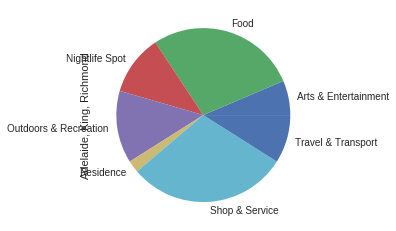

In [81]:
df_percent.iloc[0,:].plot(kind='pie')

# To Do K Means Cluster by SKLearn

In [0]:
import matplotlib.pyplot as plt  
%matplotlib inline
import numpy as np  
from sklearn.cluster import KMeans 
from sklearn.model_selection import GridSearchCV

In [41]:
ca = KMeans()
param_grid = {"n_clusters": range(2, 21)}

# run randomized search
search = GridSearchCV(
    ca,
    param_grid=param_grid
    )
fit_results=search.fit(df_percent.values)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [42]:
labels = search.predict(df_percent.values)
labels

array([ 0, 11,  1,  9,  3,  9,  8,  4, 10,  2, 10,  0,  0,  9,  2,  0, 10,
        2,  9,  3,  8,  1, 17,  8,  8,  3,  3,  2, 16,  2,  8,  2,  0, 13,
       16,  4,  1,  3,  0,  7, 10, 10,  9, 16,  4, 16,  9,  3,  9,  3,  8,
        2, 17,  1,  4,  6,  8, 11,  9,  5,  9, 10,  3,  9,  3,  9,  0,  3,
        7, 16, 16,  2, 17,  0, 17,  9, 16, 10,  3,  5, 10,  6,  8, 16,  2,
        9,  3,  3,  2,  0,  0,  2,  2,  3,  2, 16,  3,  8,  8, 17, 17,  5,
        0,  3, 11,  2,  0,  8, 17,  8,  7,  3, 11,  0, 11,  3,  4,  8,  2,
        3,  2,  4,  9, 16,  3,  4,  3, 10,  8, 11,  2,  9,  8, 10,  7,  7,
        7,  9, 11, 16,  0,  0, 10,  3,  8,  3,  2,  2,  7,  3,  8,  3,  8,
        4,  4, 16,  9, 11,  2,  9,  0,  0, 10,  4,  0,  2,  9,  0,  3,  0,
       16, 10,  4,  3, 10,  5, 16, 17,  9,  3,  8, 17,  3,  2, 13,  3, 10,
        9,  2,  6,  4,  3,  5, 11,  2,  1, 10,  2,  3, 12,  2,  9, 10,  2,
        9,  3,  2,  2,  8,  1,  0,  2,  3,  7, 11,  9,  9,  0, 10, 10, 16,
       16,  8,  0,  4,  3

In [0]:
no_labels=labels.max()

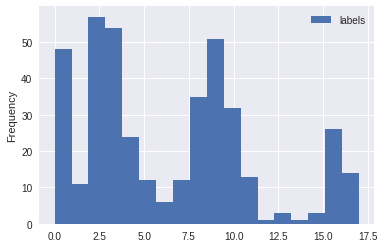

In [46]:
df_labels=pd.DataFrame({"labels":labels})
df_labels.plot(kind="hist",bins=18)
plt.show()

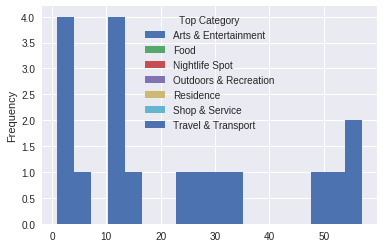

In [51]:
df_percent["Cluster"]=pd.Series(labels,index=df_percent.index)

df_percent.groupby(["Cluster"]).count().plot(kind="hist",bins=no_labels+1)

In [97]:
df_result=df_percent[["Cluster"]]
df_result.reset_index(inplace=True)
df_result.set_index("Neighborhood",inplace=True)
df_result.head()

Top Category,Cluster
Neighborhood,
"Adelaide, King, Richmond",0
Agincourt,11
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",1
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9
"Alderwood, Long Branch",3


In [0]:
df_2cities=df_2cities.join(df_result,how="left")

In [99]:
df_2cities.head()

,Venue,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category,Top Category,Cluster
Neighborhood,,,,,,,,
"Adelaide, King, Richmond",01system,43.650571,-79.384568,43.652377,-79.388886,Arts & Entertainment,Arts & Entertainment,0
"Adelaide, King, Richmond",126 Simcoe,43.650571,-79.384568,43.648792,-79.386620,Residential Building (Apartment / Condo),Residence,0
"Adelaide, King, Richmond",140 Simcoe St.,43.650571,-79.384568,43.649380,-79.387807,Residential Building (Apartment / Condo),Residence,0
"Adelaide, King, Richmond",21 Nelson Street,43.650571,-79.384568,43.649130,-79.388125,Residential Building (Apartment / Condo),Residence,0
"Adelaide, King, Richmond",7-Eleven,43.650571,-79.384568,43.651007,-79.381421,Convenience Store,Shop & Service,0


In [80]:
df_results=df_result.groupby("Cluster").agg({"Cluster":'count',"Neighborhood":lambda x: " | ".join(x)})
df_results.rename(columns={"Cluster":"Count","Neighborhood":"Borough"}, inplace=True)
df_results

,Count,Borough
Cluster,,
0,48,"Adelaide, King, Richmond | Astoria | Astoria H..."
1,11,"Agincourt North, L'Amoreaux East, Milliken, St..."
2,57,Arrochar | Bath Beach | Bay Ridge | Bellaire |...
3,54,"Alderwood, Long Branch | Baychester | Bedford ..."
4,24,Arden Heights | Blissville | Broadway Junction...
5,12,Canada Post Gateway Processing Centre | Clarks...
6,6,"CN Tower, Bathurst Quay, Island airport, Harbo..."
7,12,Borough Park | Charleston | Downsview Northwes...
8,35,Annadale | Bayside | Bedford Park | Bedford Pa...


# To view New York cluster in map

In [82]:
from geopy.geocoders import Nominatim
!{sys.executable} -m pip install folium
import folium

/bin/bash: {sys.executable}: command not found


In [0]:
address = 'New York,USA'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude

In [0]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

x = np.arange(no_labels+1)
ys = [i+x+(i*x)**2 for i in range(no_labels+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [101]:
df_2cities.head()

,Venue,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category,Top Category,Cluster
Neighborhood,,,,,,,,
"Adelaide, King, Richmond",01system,43.650571,-79.384568,43.652377,-79.388886,Arts & Entertainment,Arts & Entertainment,0
"Adelaide, King, Richmond",126 Simcoe,43.650571,-79.384568,43.648792,-79.386620,Residential Building (Apartment / Condo),Residence,0
"Adelaide, King, Richmond",140 Simcoe St.,43.650571,-79.384568,43.649380,-79.387807,Residential Building (Apartment / Condo),Residence,0
"Adelaide, King, Richmond",21 Nelson Street,43.650571,-79.384568,43.649130,-79.388125,Residential Building (Apartment / Condo),Residence,0
"Adelaide, King, Richmond",7-Eleven,43.650571,-79.384568,43.651007,-79.381421,Convenience Store,Shop & Service,0


In [105]:
df_2cities['Neighborhood Latitude']

Neighborhood
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571
Adelaide, King, Richmond    43.650571

In [114]:
df_newyork_ext=df_newyork.join(df_result,how="left",on="Neighborhood")
df_newyork_ext.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster
PostalCode,,,,,
Bronx,Wakefield,Wakefield,40.894705,-73.847201,3
Bronx,Co-op City,Co-op City,40.874294,-73.829939,3
Bronx,Eastchester,Eastchester,40.887556,-73.827806,4
Bronx,Fieldston,Fieldston,40.895437,-73.905643,11
Bronx,Riverdale,Riverdale,40.890834,-73.912585,10


In [111]:
df_result.head()

Top Category,Cluster
Neighborhood,
"Adelaide, King, Richmond",0
Agincourt,11
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",1
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9
"Alderwood, Long Branch",3


In [116]:
# create map of Toronto using latitude and longitude values
map_newyork = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# add markers to map
for lat, lng, bor, nei,cluster in zip(df_newyork_ext['Latitude'], df_newyork_ext['Longitude'], df_newyork_ext['Borough'],df_newyork_ext['Neighborhood'],df_newyork_ext['Cluster']):
  label = folium.Popup("Cluster:" + str(cluster))
  folium.CircleMarker([lat, lng],\
                       popup=label,\
        color=rainbow[cluster],
                       ).add_to(map_newyork)  
    
map_newyork